![alt text](images/HDAT9500Banner.PNG)
<br>

# Chapter 3: Model Evaluation and Improvement

#####################################################################################

Double-click to write down your name and surname.

**Name:**
Alexander

**Surname:**
Kruskal

**Honour Pledge** <p>
    
    
Declaration: <p>
    
    
I declare that this assessment item is my own work, except where acknowledged, and has not been submitted for academic credit elsewhere or previously, or produced independently of this course (e.g. for a third party such as your place of employment) and acknowledge that the assessor of this item may, for the purpose of assessing this item: 

    a. Reproduce this assessment item and provide a copy to another member of the University; and/or 
    b. Communicate a copy of this assessment item to a plagiarism checking service (which may then retain a copy of the assessment item on its database for the purpose of future plagiarism checking). 

#####################################################################################

# Assessment


Tuning parameters with Grid + cross-validation: GridSearchCV <font color=green>**(Step 6 of the ML work-flow)**</font>

Pipelines.

The test will be kept in a "safe box" to use once we have found the best parameters and the best model with Grid SearchCV.


# 1. Introduction

In this assessment, you will be asked to use 'Grid' to find the best $alpha$ ($alpha=C=1/\lambda$) and the best combination of B:M class_weight for logistic regression with Ridge (L2) regularization and 5-CV.

**NB Nomeclature: **
Training, Validation and Test Set. 

* The training set, used to train the model
* The validation set, used to evaluate model performance and adjust hyper-parameters accordingly (for example, the alpha for Ridge Regression). Therefore, the validation set is used as an intermediate step. 
* The test set, used for final model evaluation. Book 2 uses the term "validation set" for what we call "test set" in Book 1.


## 1.1. Aims of the Exercise:
 1. To become familiar with a validation set to find the best hyper-parameters of a model. Remember that the hyper-parameters are defined by the user.
 2. To become familiar with a grid search: the most commonly used method for tuning parameters is via a grid search, which entails testing many combinations of the parameters of interest.
 3. To become familiar with k-CV and grid search
 4. To become familiar with Python pipelines

 
It aligns with all of the learning outcomes of our course: 

1.	Distinguish a range of task specific machine learning techniques appropriate for Health Data Science.
2.	Design machine learning tasks for Health Data Science scenarios.
3.	Construct appropriate training and test sets for health research data.


## 1.2. Jupyter Notebook Instructions
1. Read the content of each cell.
2. Where necessary, follow the instructions that are written in each cell.
3. Run/Execute all the cells that contain Python code sequentially (one at a time), using the "Run" button.
4. For those cells in which you are asked to write some code, please write the Python code first and then execute/run the cell.
 
## 1.3. Tips
 1. The square brackets on the left hand side of each cell indicate whether the cell has been executed or not. Empty square brackets mean that the cell has not been executed, whereas square brackets that contain a number means that the cell has been executed. Run all of the cells in sequence, using the "Run" button.
 2. To edit this notebook, just double-click in each cell. In the document, each cell can be a "Code" cell or "text-Markdown" cell. To choose between these two options, go to the combo-box above. 
 3. If you want to save your notebook, please make sure you press the "floppy disk" icon button above. 
 4. To clean the content of all cells and re-start Notebook, please go to Cell->All Output->Clear

# 2. Load dataset

In [1]:
import sys
print(sys.version)


import numpy as np
import pandas as pd
from IPython.display import display

from plotnine import *

3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]


In [2]:
dataframe = pd.read_csv('data/breast-cancer-wisconsin-data/data.csv', sep=',')

In [3]:
# Sanity Check:
display(dataframe[:][:5])
dataframe.shape
dataframe.diagnosis.value_counts()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


B    357
M    212
Name: diagnosis, dtype: int64

# 3. Grid Search with Cross-Validation: GridSearchCV

The most commonly used method for tuning parameters is via a grid search, which entails testing many combinations of the parameters of interest.<p>
    
 We want to utilise the benefits of cross-validation with the grid search. We will seek to find the model with the best accuracy by using cross-validation. We will use the "GridSearchCV" class from sklearn.
 
 http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    
We have two primary hyper-parameters that we would like to tune:
* C, ($C=alpha=1/\lambda$)
* class_weight, the class weights.
<p>
    
Let's say we want to try:

1. C = 0.001, 0.01, 0.1, 1, 10, 100. And for 

2. class_weight = 'balanced', {'B':0.1, 'M':0.9}, {'B':0.2, 'M':0.8}, {'B':0.3, 'M':0.7}, {'B':0.4, 'M':0.6}, and {'B':0.5, 'M':0.5}. 


Note that class_weight = {'B':0.5, 'M':0.5} corresponds to no class weighting, as the weightings are equal. As there are 6 cases of C, and 6 of class weight, there are 6 times 6 = 36 total combinations of C and class weight.<p>
    
We will choose **L2 regularization (ridge) for this problem**. As we are using a grid, and later a grid in combination with cross-validation, we have to keep in our minds *computational complexity*. L2 has a closed form solution because it relies on squaring the beta coefficients. L1 does not have a closed form solution as it involves an absolute value. For this reason, L1 is computationally more expensive, as we can't solve it in terms of matrix math, and most rely on approximations (in the lasso case, coordinate descent). This means L2 will be much faster to implement.

### <font color='blue'> Question 1: Split the whole dataset into a train and a test set (20% of the total). Keep the test set aside (hidden inside a box as we mentioned in the videos) until the very end (15 marks)</font>

 <font color='green'> *NB*: We stratify in order to have the same number of classes in the different splits.</font>

In [4]:
# Q1: Write Python Code Here
# Split data into inputs and output
X = dataframe.drop(['diagnosis'], axis = 1)
y = dataframe[['diagnosis']].values

#split into test and training
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2,random_state=0)

## 3.1. Define the Pipeline

As in exercise 1, we will have to use a pipeline in order to also standardize the features for each iteration of the cross-validation.


### <font color='blue'> Question 2: Define the scaler we will use, and the estimator. As before, choose the scaler ("Transform") to be StandardScaler(), and the estimator ("Estimator") to be L2 Logistic Regression. (5 marks)</font>

To read about Pipelines:
1. https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
2. https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976


In [5]:
# Q2: Write Python Code Here
from sklearn.pipeline import Pipeline 

# Scaler/Standardization
from sklearn.preprocessing import StandardScaler
Scaler = StandardScaler()

#LogReg set-up
from sklearn.linear_model import LogisticRegression
LogReg = LogisticRegression(penalty = 'l2')

# PipeLine
pipe = Pipeline([('Transform', Scaler), ('Estimator', LogReg)])


## 3.2. Define the parameter grid

### <font color='blue'> Question 3: Define the parameter grid. This is the 2-dimensional range we wish to draw parameter values from. Call this object 'param_grid'. (20 marks)</font>

 **Important:** as we are using a pipeline, there are two processes that are executed for each iteration of the cross-validation. First, the standardisation, then the fitting of the logistic model. This means we have to indicate which of these processes our specified parameters should be used for. That is, the computer may try to fit class_weight into StandardScaler if we forget to tell it not to. Notice above that we have named our logistic model 'Estimator'. This means we can designate its parameters by naming the hyper-parameters in parameter grid "Estimator__'parameter_name'". **For example, we tell the computer that C is meant for the logistic regression estimator by defining it as 'Estimator__C' in the param_grid.**

**Coment**

There is enough computing power to try many class weights, but realistically with a bigger data set, we would probably only try {0:0.5, 1:0.5}, {0:0.6, 1:0.4}, {0:0.7, 1:0.3}, {0:0.8, 1:0.2}, {0:0.9, 1:0.1} because there are more class 0 (benign) than class 1 (malignant) - note that the best accuracy is with {0:0.4, 1:0.6}.

In [6]:
# Q3: Write Python Code Here
param_grid = {'Estimator__C': 
              [0.001, 0.01, 0.1, 1, 10, 100],
              'Estimator__class_weight': 
              [{0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}, {0:0.4, 1:0.6}, 
               {0:0.5, 1:0.5}, {0:0.6, 1:0.4}, {0:0.7, 1:0.3}, {0:0.8, 1:0.2}, 
               {0:0.9, 1:0.1}]}
              

print("Parameter grid:")
print("class_weight: {}".format(param_grid['Estimator__class_weight']))
print("C: {}".format(param_grid['Estimator__C']))

Parameter grid:
class_weight: [{0: 0.1, 1: 0.9}, {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}, {0: 0.5, 1: 0.5}, {0: 0.6, 1: 0.4}, {0: 0.7, 1: 0.3}, {0: 0.8, 1: 0.2}, {0: 0.9, 1: 0.1}]
C: [0.001, 0.01, 0.1, 1, 10, 100]


### <font color='blue'> Question 4: Initialise the GridSearchCV class by passing it the pipeline we have created, *pipe*, our paramater grid, *param_grid*, and specifying how many folds we would like. We must consider the computational complexity of the algorithm, so we can't set cv too high. We choose 5 folds.(5 marks)</font>

In [7]:
# Q4: Write Python Code Here
#change y train to binary
y_train_binary = [0 if x=='B' else 1 for x in y_train] #B=0, M=1


B=0 and M=1
cancer positive =1

In [8]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5)

In [9]:
grid_search.fit(X_train, y_train_binary)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('Transform', StandardScaler(copy=True, with_mean=True, with_std=True)), ('Estimator', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'Estimator__C': [0.001, 0.01, 0.1, 1, 10, 100], 'Estimator__class_weight': [{0: 0.1, 1: 0.9}, {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}, {0: 0.5, 1: 0.5}, {0: 0.6, 1: 0.4}, {0: 0.7, 1: 0.3}, {0: 0.8, 1: 0.2}, {0: 0.9, 1: 0.1}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [10]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

Best parameters: {'Estimator__C': 1, 'Estimator__class_weight': {0: 0.4, 1: 0.6}}
Best estimator:
Pipeline(memory=None,
     steps=[('Transform', StandardScaler(copy=True, with_mean=True, with_std=True)), ('Estimator', LogisticRegression(C=1, class_weight={0: 0.4, 1: 0.6}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])
Best cross-validation score: 0.9846


### <font color='blue'> Question 5: What score (performance metric) are we using in the GridSearchCV above? If we used the f1 score instead, what command or commands should be included? - (10 marks)</font>

<b> Write your thoughts here:</b>
#####################################################################################################################

The Scoring performance GridSearchCV uses accuracay automatically.
To use f1 score instead we would add in "scoring = 'f1'"


#####################################################################################################################

In [11]:
# Q5: Write Python code here
grid_search_f1 = GridSearchCV(pipe, param_grid=param_grid, scoring = 'f1', cv=5)

## 3.3. Find the best parameters

Now train the grid_search object. Note that grid_search behaves similarly to other classifiers, in the sense that we can use the methods fit, predict and score with it. When we use fit, it performs the grid cross-validation we designed during its initialisation.

### <font color='blue'> Question 6: Fit the GridSearchCV you created before and show the best parameters and score out of all the folds - (15 marks)</font>

If you are looking for the best parameters for the original grid search, that is above.

If you are looking for the best parameters for f1, that is below.

In [12]:
# Q6: Write Python code here
grid_search_f1.fit(X_train, y_train_binary)

# It takes a while to run ...

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('Transform', StandardScaler(copy=True, with_mean=True, with_std=True)), ('Estimator', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'Estimator__C': [0.001, 0.01, 0.1, 1, 10, 100], 'Estimator__class_weight': [{0: 0.1, 1: 0.9}, {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}, {0: 0.5, 1: 0.5}, {0: 0.6, 1: 0.4}, {0: 0.7, 1: 0.3}, {0: 0.8, 1: 0.2}, {0: 0.9, 1: 0.1}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [13]:
print('******Best parameters for grid_search_f1*******\n')
print("Best parameters: {}".format(grid_search_f1.best_params_))
print("Best estimator:\n{}".format(grid_search_f1.best_estimator_))
print("Best cross-validation score f1: {:.4f}".format(grid_search_f1.best_score_))

******Best parameters for grid_search_f1*******

Best parameters: {'Estimator__C': 1, 'Estimator__class_weight': {0: 0.4, 1: 0.6}}
Best estimator:
Pipeline(memory=None,
     steps=[('Transform', StandardScaler(copy=True, with_mean=True, with_std=True)), ('Estimator', LogisticRegression(C=1, class_weight={0: 0.4, 1: 0.6}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])
Best cross-validation score f1: 0.9793


## 3.4. Visualise the grid results
The results from the cross-validated grid search are stored in cv_results_

In [14]:
#!pip install mglearn
import mglearn

In [15]:
import warnings; warnings.simplefilter('ignore') #prevent warnings

# convert results to DataFrame
results = pd.DataFrame(grid_search.cv_results_) 
# show the first few rows 
display(results[:][:5])

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_Estimator__C,param_Estimator__class_weight,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.004588,0.001598,0.945055,0.943956,0.001,"{0: 0.1, 1: 0.9}","{'Estimator__C': 0.001, 'Estimator__class_weig...",47,0.967033,0.945055,...,0.945055,0.939560,0.912088,0.950549,0.978022,0.939560,0.002720,0.001353,0.025059,0.004112
1,0.003191,0.000797,0.947253,0.947253,0.001,"{0: 0.2, 1: 0.8}","{'Estimator__C': 0.001, 'Estimator__class_weig...",43,0.967033,0.942308,...,0.945055,0.950549,0.901099,0.956044,0.978022,0.939560,0.000400,0.000399,0.026374,0.005867
2,0.002591,0.000801,0.942857,0.946703,0.001,"{0: 0.3, 1: 0.7}","{'Estimator__C': 0.001, 'Estimator__class_weig...",53,0.967033,0.945055,...,0.945055,0.945055,0.901099,0.953297,0.967033,0.942308,0.000793,0.000400,0.024474,0.003727
3,0.002593,0.000797,0.945055,0.947253,0.001,"{0: 0.4, 1: 0.6}","{'Estimator__C': 0.001, 'Estimator__class_weig...",47,0.967033,0.945055,...,0.956044,0.945055,0.901099,0.950549,0.967033,0.945055,0.000799,0.000398,0.025059,0.002692
4,0.002593,0.000205,0.942857,0.947802,0.001,"{0: 0.5, 1: 0.5}","{'Estimator__C': 0.001, 'Estimator__class_weig...",53,0.967033,0.947802,...,0.956044,0.945055,0.890110,0.950549,0.967033,0.945055,0.000488,0.000411,0.028991,0.002457


In [16]:
scores = np.array(results.mean_test_score)
scores = scores.reshape(6, 9) 
# reshape: first index = number of values of C, second index = number of values of dict

# Take transpose because we want class_weight on the y axis, so we can more easily see the tick labels
scores = np.transpose(scores)

print(scores)

[[0.94505495 0.94505495 0.94945055 0.95164835 0.95384615 0.95604396]
 [0.94725275 0.95604396 0.96923077 0.97142857 0.96703297 0.95824176]
 [0.94285714 0.96483516 0.98241758 0.97802198 0.97582418 0.96043956]
 [0.94505495 0.96483516 0.97802198 0.98461538 0.97582418 0.96043956]
 [0.94285714 0.96703297 0.97802198 0.98241758 0.97362637 0.95824176]
 [0.94725275 0.96263736 0.97582418 0.98021978 0.97582418 0.95384615]
 [0.94505495 0.95824176 0.96483516 0.97802198 0.97802198 0.95604396]
 [0.94505495 0.95164835 0.95384615 0.96483516 0.97582418 0.95164835]
 [0.94505495 0.94725275 0.94725275 0.95164835 0.96703297 0.96703297]]


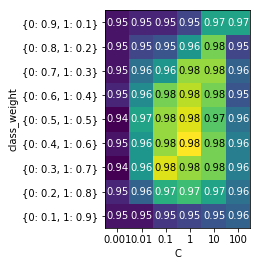

In [17]:
# plot the mean cross-validation scores
mglearn.tools.heatmap(scores, 
                      ylabel='class_weight', 
                      yticklabels=param_grid['Estimator__class_weight'], 
                      xlabel='C', 
                      xticklabels=param_grid['Estimator__C'], 
                      cmap="viridis")

### <font color='blue'> Question 7: Interpret the heatmap - (10 marks)</font>

<b> Write your thoughts here:</b>
#####################################################################################################################

The heat map above shows the best values in the midddle of the map,.

This is a good sign because this means there is enough range in hyper parameters and not too
little variation either.

It also shows that the best model based on accuraccy is present as it gets worse outside of the ranges tested.


#####################################################################################################################

## 3.5. Evaluate on the performance of the resulting model

Recall that to this point we have not used the test set - only the training set was used for tuning the parameters (<font color=green>**(Step 5 of the ML work-flow).** As you can see, we went from step 6 (hyper-parameter tuning), back to step 4 (once we selected the best hyper-parameteres, we trained the model with those parameters); subsequently, we move to step 5 (Evaluation of the model).</font>


"Fitting the GridSearchCV object not only searches for the best parameters, but also
automatically fits a new model on the whole training dataset with the parameters that
yielded the best cross-validation performance".

### <font color='blue'> Question 8: Calculate confusion matrix, accuracy, recall, precision and f1 score. Comment on the results below - (20 marks)</font>
<p><font color='green'> Tip: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html </font></p>

### <font color='black'>Fit model to whole training data</font>

In [18]:
#refit the model for the whole training data using the best parameters obtained during cross-validation
scaler = StandardScaler()
scaler.fit(X_train)
# rescale the training data
X_train_scaled = scaler.transform(X_train)
# scale the test data 
X_test_scaled = scaler.transform(X_test)


In [19]:
#fit model
logReg = LogisticRegression(C = 1 , penalty = 'l2', class_weight = {'B':.4, 'M':.6}).fit(X_train_scaled, y_train.ravel()) 
logReg

LogisticRegression(C=1, class_weight={'B': 0.4, 'M': 0.6}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [20]:
#make a y_pred based on best model
y_pred= logReg.predict(X_test_scaled)

#make y_pred and y_test binary
y_pred_binary = [0 if x=='B' else 1 for x in y_pred] #B=0, M=1
y_test_binary = [0 if x=='B' else 1 for x in y_test] #B=0, M=1

In [21]:
#confusion matrix
from sklearn import metrics

confusion = metrics.confusion_matrix(y_test, y_pred, labels = ['M','B'])
print("Confusion matrix:\n{}".format(confusion))



#accuracy
score = logReg.score(X_test_scaled, y_test)
print("Accuracy for model:\n{}".format(score))


#recall, precision, f1 scores
print("********************************************************")
print('Best accuracy from cross-validation log reg model:')
print(metrics.classification_report(y_test_binary, y_pred_binary))

Confusion matrix:
[[40  2]
 [ 4 68]]
Accuracy for model:
0.9473684210526315
********************************************************
Best accuracy from cross-validation log reg model:
             precision    recall  f1-score   support

          0       0.97      0.94      0.96        72
          1       0.91      0.95      0.93        42

avg / total       0.95      0.95      0.95       114



<b> Write your thoughts here:</b>
#####################################################################################################################

The accuracy is only 94% compared to 98% accross the cross-validation, showing that it may be slighly over-fitted to the training data.

Also, the precision of malignant (cancerous), is probably a better measure for the predictive model as long as there are not too many false positives (adding cost for extra tests) because missing cancer is much more harmful and costly than a few extra false positives.

Using F1 score as the scoring for the grid search may make a better model because it is an average between precision and recall and would decrease false positives while also keeping false negatives low.


#####################################################################################################################